In [1]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import time
# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from aind_vr_foraging_analysis.utils.plotting import plotting_friction_experiment as f
from aind_vr_foraging_analysis.utils.parsing import data_access, parse, AddExtraColumns
import aind_vr_foraging_analysis.utils.plotting as plotting

from matplotlib.backends.backend_pdf import PdfPages
sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='yellow'
odor_list_color = [color1, color2, color3, color4]

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = r'Z:/scratch/vr-foraging/data/'
results_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\Conferences\Lakes 2025\figures'
data_path = r'C:\git\Aind.Behavior.VrForaging.Analysis\data'

palette = {
    'control': 'darkgrey',  # Red
    'friction_high': "#1e4110",  # Purple
    'friction_med': "#120c8a",  # Lighter Purple
    'friction_low': '#9e9ac8',  # Lightest Purple
    'distance_extra_short': 'crimson',  # Blue
    'distance_short': 'pink',  # Lighter Blue
    'distance_extra_long': '#fd8d3c',  # Yellow
    'distance_long': '#fdae6b'  # Lighter Yellow
}

color_dict_label = {'Ethyl Butyrate': color1, 'Alpha-pinene': color2, 'Amyl Acetate': color3, 
                    '2-Heptanone' : color2, 'Methyl Acetate': color1, 'Fenchone': color3, '2,3-Butanedione': color4,
                    'Methyl Butyrate': color1, '60': color2, '90': color1, "0": color3}

from matplotlib.backends.backend_pdf import PdfPages as pdf


In [34]:
# Recover and clean batch 4 dataset
# batch4 = pd.read_csv(data_path + 'batch_4.csv') # if you want the original dataset
batch4 = pd.read_csv(os.path.join(data_path, 'batch_4_fixed_interpatch.csv'))

# These mice are in the dataset but didn't perform the manipulation
batch4 = batch4[(batch4['mouse'] != 754573)&(batch4['mouse'] != 754572)&(batch4['mouse'] != 745300)&(batch4['mouse'] != 745306)&(batch4['mouse'] != 745307)]

batch4["session"] = batch4["session"].apply(lambda x: str(x).split('_')[-1])
batch4 = batch4[batch4['label'] == 'OdorSite']

## Micr with weird behavior
batch4 = batch4.loc[(batch4.mouse != 754577)&(batch4.mouse != 754575)]

# Import data from batch3
batch3 = pd.read_csv(os.path.join(data_path,  'batch_3.csv'))
batch3 = batch3.loc[(batch3.mouse != 715866)]

# Merge both datasets
df = pd.concat([batch3, batch4], ignore_index=True)

df= df.loc[~df.patch_label.isin(['patch_delayed', 'patch_no_reward', 'patch_single', 'delayed', 'single', 'no_reward', 'PatchZB'])]

df['patch_label'] = df['patch_label'].replace({'Alpha pinene': '60','Alpha-pinene': '60', 'Methyl Butyrate': '90', 'Ethyl Butyrate': '90', 'Amyl Acetate': '0', 
                                               '2,3-Butanedione': 'slow', '2-Heptanone': 'slow',  'Methyl Acetate':'fast', 'Fenchone':'0'})
df['experiment'] = df['experiment'].replace({'base': 'control'})

In [28]:
df = df[(df['engaged'] == 1)|(df['patch_number'] <= 20)]
df = df.loc[(df['experiment']== 'experiment2')&(df['patch_label'] != '0')]

test = df.groupby(['mouse', 'session', 'patch_number']).site_number.max().reset_index()
test.rename(columns={'site_number': 'total_stops'}, inplace=True)

df = df.merge(
    test,
    on=['mouse', 'session', 'patch_number'], how='left')

In [44]:
df = df.loc[(df['experiment']== 'experiment2')&(df['patch_label'] != '0')]
all_epochs = df.copy()

In [45]:
all_epochs['previous_length'] = all_epochs['length'].shift(1).round(0)

all_epochs['site_number_norm'] = (
    all_epochs.groupby(['session', 'mouse'])['site_number']
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0)
)
all_epochs['site_number_norm'] = all_epochs['site_number_norm'].round(2)

all_epochs['site_number_norm_patches'] = (
    all_epochs.groupby(['mouse', 'session', 'patch_number'])['site_number']
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else np.nan)
)
all_epochs['site_number_norm_patches'] = all_epochs['site_number_norm_patches'].round(2)

all_epochs['segment'] = np.where(all_epochs['site_number_norm_patches'] < 0.5, 'early', 'late')

all_epochs['patch_label'] = all_epochs['patch_label'].replace({'Alpha pinene': '60','Alpha-pinene': '60', 'Methyl Butyrate': '90', 'Ethyl Butyrate': '90', 'Amyl Acetate': '0', 
                                            '2,3-Butanedione': 'slow', '2-Heptanone': 'slow',  'Methyl Acetate':'fast', 'Fenchone':'0', 'PatchA': '60', 'PatchB': '90', 'PatchC': '0', 'PatchD': 'slow', 'PatchE': 'fast'})

all_epochs['last_site'] = all_epochs['last_site'].bfill()
all_epochs['site_number'] = all_epochs['site_number'].bfill()
all_epochs['is_choice'] = all_epochs['is_choice'].astype(float)
all_epochs['previous_length'] = all_epochs['length'].shift(1).round(0)
all_epochs = all_epochs.loc[all_epochs['engaged']==1]

In [46]:
# Bin previous_length (e.g., 20–25, 25–30, ..., 95–100)
lag = 10
bins = np.arange(20, 100+lag, lag)
labels = [f"{b}-{b+lag}" for b in bins[:-1]]

all_epochs['previous_length_bin'] = pd.cut(all_epochs['previous_length'], bins=bins, labels=labels, right=False)
all_epochs['length_bin'] = pd.cut(all_epochs['length'], bins=bins, labels=labels, right=False)

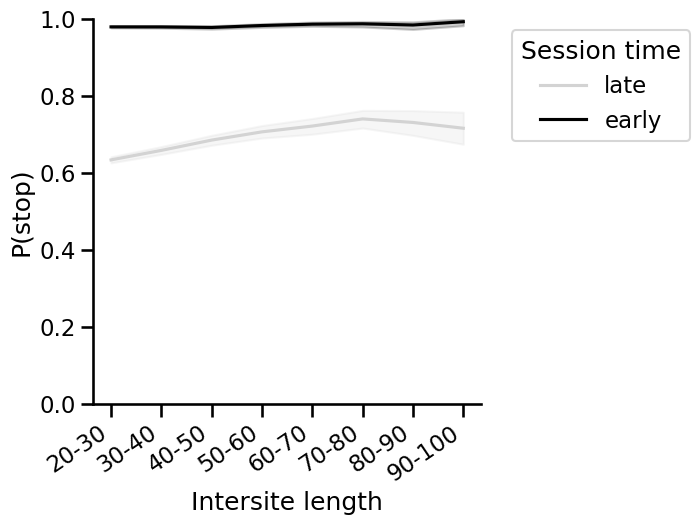

In [47]:
# Plot

reward_sites = all_epochs.loc[all_epochs['label'] == 'OdorSite']

fig, ax = plt.subplots(figsize=(5,5))
dictionary = {'fast': color2, 'slow': color1, '0.0': color3}
sns.lineplot(
    data=reward_sites.loc[reward_sites['patch_label']!= '0.0'],
    x='previous_length_bin',
    y='is_choice',
    hue='segment',
    palette = [ 'lightgrey','black'],
    errorbar='ci',  # default; can also be "sd", None, etc.
    # palette={'60':'#1b9e77', '90':'#d95f02', '0':'#7570b3'}
)
plt.ylim(0, 1)
sns.despine(ax=ax)
plt.xlabel('Intersite length')
plt.ylabel('P(stop)')
plt.xticks(rotation=34, ha='right')
plt.legend(title='Session time', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

plt.savefig(os.path.join(results_path, 'pleave_intersite_by_patch_type.pdf'), bbox_inches='tight')
sns.despine()

In [ ]:
with PdfPages(os.path.join(results_path, 'reproduce_residency_figure.pdf')) as pdf:
    for session in df.session.unique():
        plot = df.loc[df.session == session]
        fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

        axes = ax[0]
        sns.scatterplot(data=plot, x='odor_sites', y='reward_probability', hue='patch_label', palette=color_dict_label, s=50, style='engaged',zorder=2, edgecolor='black', ax=axes, legend=False)
        sns.lineplot(data=plot, x='odor_sites', y='reward_probability', color='grey', zorder=1, ax=axes)
        axes.set_ylim(-0.05, 1)
        axes.set_ylabel('Reward Probability')

        axes = ax[1]
        sns.scatterplot(data=plot, x='odor_sites', y='patch_label', hue='patch_label', palette=color_dict_label, s=50, zorder=2, edgecolor='black', ax=axes)
        sns.lineplot(data=plot, x='odor_sites', y='patch_label', color='grey', zorder=1, ax=axes)

        axes.set_ylabel('Resident Patch')
        axes.set_xlabel('Odor Site #')

        plt.legend(title='Odor Site', bbox_to_anchor=(1.05, 1), loc='upper left')
        sns.despine()
        plt.tight_layout()
        pdf.savefig(fig)

In [ ]:
def expand_reward_parameters(df: pd.DataFrame, window_size: int = 6) -> pd.DataFrame:
    """
    Expands the reward parameters for each patch in the dataframe.
    Args:
        window_size (int): The size of the rolling window for calculating the running average rate.
    Returns:
        pd.DataFrame: The dataframe with expanded reward parameters.
    """
    # Other reward parameters
    df['rate_since_entry'] = df['cumulative_rewards'] / df['time_since_entry']
    df['stops'] = df['site_number'] + 1
    df['rate_stops'] = df['cumulative_rewards'] / df['stops']
    
    # Compute reward rate according to the window
    df_cum = pd.DataFrame()
    for mouse in df.mouse.unique():
        for sn in df.loc[(df.mouse == mouse)].session_n.unique():
            print(mouse)
            df_session = df.loc[(df.mouse == mouse)&(df.session_n == sn)].copy()

            df_sorted = df_session.sort_values(['patch_number', 'site_number'])

            # Step 2: Within each patch_number, forward-fill the last reward time
            df_sorted['last_reward_time'] = (
                df_sorted
                .groupby('patch_number')['reward_onset_time']
                .transform(lambda x: x.ffill())
            )

            # If needed, restore original order
            df_final = df_sorted.sort_values('start_time')

            df_final['fixed_last_reward'] = df_final['last_reward_time'].shift(1)
            df_final['local_average_rate'] = 5 / (df_final['start_time']-df_final['fixed_last_reward'])

            # Make sure the dataframe is sorted correctly
            df_final = df_final.sort_values(['patch_number', 'site_number'])

            # Compute rolling average within patch, allowing fewer points at the start
            df_final['running_avg_rate'] = (
                df_final
                .groupby('patch_number')['is_reward']
                .rolling(window=window_size, min_periods=1)
                .mean()
                .reset_index(level=0, drop=True)
            )

            df_cum  = pd.concat([df_final, df_cum], ignore_index=True)
            
    return df_cum.copy()

In [ ]:
df = expand_reward_parameters(df, window_size = 8)

In [ ]:
# Group the data as you described
patch_df = (
    # df[((df.odor_label != 'Ethyl Butyrate') & (df.site_number > 1))|((df.site_number > 1)&(df.odor_label == 'Ethyl Butyrate'))&(df['last_site'] == 1)]
    # df.loc[(df['last_site'] == 1)&(df.site_number > 0)]
    df
    .groupby(['mouse', 'session_n', 'session','experiment','patch_label', 'patch_number'])
    .agg(
        reward_probability=('reward_probability', 'min'),
        stops=('site_number', 'max'),
        total_rewards=('cumulative_rewards', 'max'),
        consecutive_rewards = ('consecutive_rewards', 'max'),
        total_failures=('cumulative_failures', 'max'),
        consecutive_failures = ('consecutive_failures', 'max'), 
        rate_since_entry=('rate_since_entry', 'mean'), 
        rate_stops = ('rate_stops', 'mean'), 
        running_avg_rate = ('running_avg_rate', 'mean'), 
        local_average_rate = ('local_average_rate', 'mean'), 
        patch_residency = ('time_since_entry', 'max')
        )
    .reset_index()
)
session_df = (
    patch_df
    .groupby(['mouse', 'session_n', 'session', 'experiment','patch_label'])
    .agg(
            reward_probability = ('reward_probability','mean'), 
            stops = ('stops','mean'),
            total_stops = ('stops','sum'), 
            total_rewards = ('total_rewards','mean'),
            consecutive_rewards = ('consecutive_rewards','mean'),
            total_failures = ('total_failures','mean'),
            consecutive_failures = ('consecutive_failures','mean'), 
            patch_number = ('patch_number','nunique'), 
            rate_since_entry=('rate_since_entry', 'mean'), 
            rate_stops = ('rate_stops', 'mean'), 
            running_avg_rate = ('running_avg_rate', 'mean'), 
            local_average_rate = ('local_average_rate', 'mean'),
            patch_residency = ('patch_residency', 'mean')
         )
    .reset_index()
)

# These df summarizes metrics for each mouse (averages all sessions and all patches withing that session)
mouse_df = ( 
        patch_df
        .groupby(['mouse','experiment','patch_label'])
        .agg(
            reward_probability = ('reward_probability','mean'), 
            stops = ('stops','mean'),
            total_stops = ('stops','sum'), 
            total_rewards = ('total_rewards','mean'),
            consecutive_rewards = ('consecutive_rewards','mean'),
            total_failures = ('total_failures','mean'),
            consecutive_failures = ('consecutive_failures','mean'), 
            patch_number = ('patch_number','nunique'), 
            rate_since_entry=('rate_since_entry', 'mean'), 
            rate_stops = ('rate_stops', 'mean'), 
            running_avg_rate = ('running_avg_rate', 'mean'), 
            local_average_rate = ('local_average_rate', 'mean'),
            patch_residency = ('patch_residency', 'mean')
            )
        .reset_index()
)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4.5))
patch_df['mouse'] = patch_df['mouse'].astype(str)
plot = patch_df.groupby(['mouse']).agg(session_count=('session_n', 'nunique')).reset_index()
sns.scatterplot(data=plot, x='mouse', y='session_count',hue='mouse', legend=False)
plt.xticks(rotation=45)
plt.tight_layout()
sns.despine()

## **P(leaving) on the 6th depending on different fra ction of rewards**

In [ ]:
df.sort_values(['mouse', 'session', 'patch_number', 'site_number'], inplace=True)
df['next_choice'] = df.is_choice.shift(-1)
test = df.loc[(df.total_stops >= 5)].copy()
test = test.loc[test.site_number == 5]

In [ ]:
sns.relplot(data=test, 
            x='cumulative_rewards', 
            y='next_choice', 
            hue='patch_label', 
            col='mouse',
            col_wrap = 5,
            kind='line',
            palette=odor_list_color, 
            marker='o')

## **Fraction of rewards across stops conditions**

In [ ]:
patch_df['fraction_rewards'] = patch_df['total_rewards'] / (patch_df['stops'])

In [ ]:
plot = patch_df.loc[patch_df.patch_label.isin(['60', '90']) & (patch_df.experiment  == 'control')].groupby(['mouse', 'session', 'patch_label']).agg({'fraction_rewards': 'mean', 'stops': 'mean'}).reset_index()
sns.kdeplot(data=plot, x='stops', y='fraction_rewards', hue='patch_label',  alpha=0.7, palette=color_dict_label)
sns.despine()

In [ ]:
# Prep the data
plot = patch_df.loc[
    patch_df.patch_label.isin(['60', '90']) & (patch_df.experiment == 'control')
].groupby(['mouse', 'session', 'patch_number', 'patch_label']).agg({
    'fraction_rewards': 'mean',
    'stops': 'mean'
}).reset_index()

for mouse, ax in zip(plot.mouse.unique(), plt.subplots(4, 4, figsize=(24, 16))[1].flatten()):
    mouse_data = plot[plot['mouse'] == mouse]
    sns.kdeplot(data=mouse_data, x='stops', y='fraction_rewards', hue='patch_label', ax=ax, palette=color_dict_label, alpha=0.6)
    ax.set_title(f'Mouse {mouse}')
    ax.set_xlabel('Stops')
    ax.set_ylabel('Fraction Rewards')
    sns.despine(ax=ax)
    
plt.tight_layout()

In [ ]:
# Prep the data
plot = patch_df.loc[
    patch_df.patch_label.isin(['60', '90']) & (patch_df.experiment == 'control')
].groupby(['mouse', 'session', 'patch_number', 'patch_label']).agg({
    'fraction_rewards': 'mean',
    'stops': 'mean'
}).reset_index()

# Create FacetGrid
g = sns.FacetGrid(
    plot,
    col='mouse',
    hue='patch_label',
    col_wrap=5,
    palette=color_dict_label,
    height=3,
    sharex=True,
    sharey=True
)

# Plot raw data
g.map_dataframe(sns.scatterplot, x='stops', y='fraction_rewards', alpha=0.7)

# Plot polynomial fit
from numpy.polynomial.polynomial import Polynomial
import numpy as np

def poly_fit(data, color, **kwargs):
    x = data['stops']
    y = data['fraction_rewards']
    if len(x) >= 3:  # Need at least 3 points for 2nd-degree fit
        p = Polynomial.fit(x, y, deg=2)
        x_fit = np.linspace(x.min(), x.quantile(0.995), 100)
        y_fit = p(x_fit)
        plt.plot(x_fit, y_fit, color=color, lw=2)

g.map_dataframe(poly_fit, color='black')

    

g.add_legend()
g.set_axis_labels("Stops", "Fraction Rewards")
plt.tight_layout()
plt.show()


In [ ]:

# Prep the data
plot = patch_df.loc[
    patch_df.patch_label.isin(['60', '90']) & (patch_df.experiment == 'control')
].groupby(['mouse', 'session', 'patch_number', 'patch_label']).agg({
    'fraction_rewards': 'mean',
    'stops': 'mean'
}).reset_index()

sns.jointplot(data=plot, x='stops', y='fraction_rewards', hue='patch_label', kind='kde', palette=color_dict_label, alpha=0.7)
plt.xlabel('Stops')
plt.ylabel('Fraction Rewards')
sns.despine()
plt.legend(title='Patch Label', loc='upper right')

## **Histograms and kernel density plots**

In [ ]:
variable = 'patch_residency'

if variable == 'reward_probability':
    bins = np.arange(0, 1.1, 0.05)
    xlabel = 'P(reward)'
    
elif variable == 'total_rewards':
    # Define bin edges and centers
    bins = np.arange(0, 15, 1)
    xlabel = 'Total rewards'
    
elif variable == 'stops':
    bins = np.arange(0, 30, 1)
    xlabel = 'Total stops'
    
elif variable == 'consecutive_failures':
    bins = np.arange(0, 8, 0.2)
    xlabel = 'Consecutive failures'

elif variable == 'patch_residency':
    bins = np.arange(0, 250, 10)
    xlabel = 'Patch redicency time (s)'

In [ ]:
from scipy.stats import gaussian_kde

bin_centers = bins

# Store KDE values per patch label
labels = session_df['patch_label'].unique()
kde_dict = {label: [] for label in labels}

# Group by mouse/session/patch to compute KDE per session
for (session_n, label), group in session_df.groupby(['session_n', 'patch_label']):
    data = group[variable].dropna().values
    if len(data) > 1:  # KDE requires >1 point
        kde = gaussian_kde(data, bw_method='scott')  # or 'silverman' or a float
        kde_values = kde(bin_centers)
        kde_values /= np.trapz(kde_values, bin_centers)  # normalize to area=1
        kde_dict[label].append(kde_values)

# Average KDEs per label
mean_kdes = {label: np.mean(kdes, axis=0) for label, kdes in kde_dict.items()}
mean_total_rewards = session_df.groupby('patch_label')[variable].mean()


fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), constrained_layout=True)

for label, kde in mean_kdes.items():
    ax.plot(bin_centers, kde, label=label, color=color_dict_label[label])
    
    # Optional: vertical line for mean total reward
    ax.axvline(mean_total_rewards[label], color=color_dict_label[label], linestyle=':', linewidth=2, alpha=0.8)

ax.set_title(f'Average per-session KDE per patch (N = {session_df.mouse.nunique()} mice)')
ax.set_xlabel(xlabel)
ax.set_ylabel('Average Session Density')
ax.legend(title='Patch Label')
sns.despine()


In [ ]:
bin_centers = (bins[:-1] + bins[1:]) / 2

# Store histograms for each patch label
labels = session_df['patch_label'].unique()
hist_dict = {label: [] for label in labels}

# Group by (session, patch_label), normalize within each session
for (session_n, label), group in session_df.groupby(['session_n', 'patch_label']):
    hist, _ = np.histogram(group[variable], bins=bins, density=True)
    hist_dict[label].append(hist)

# Compute mean histogram per label
mean_hists = {label: np.mean(hists, axis=0) for label, hists in hist_dict.items()}

mean_total_rewards = session_df.groupby('patch_label')[variable].mean()

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), constrained_layout=True)

for label, hist in mean_hists.items():
    ax.plot(bin_centers, hist, drawstyle='steps-mid', label=label, color=color_dict_label[label])

    mean_val = mean_total_rewards[label]
    ax.axvline(mean_val, color=color_dict_label[label], linestyle=':', linewidth=2, alpha=0.8)

# Labels and style
ax.set_title(f'N = {session_df.mouse.nunique()} mice')
ax.set_xlabel(xlabel)
ax.set_ylabel('Average Session Density')
ax.legend(title='Patch Label')
sns.despine()


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), constrained_layout=True, sharex=True, sharey=True)

sns.histplot(data=session_df, x=variable, hue='patch_label', element='step', fill=False, palette=color_dict_label, stat='density', bins= bins, legend=False, ax=ax)
ax.set_title(f'N = {len(session_df.mouse.unique())} mice')
ax.set_xlabel(xlabel)
ax.set_ylabel('Density')
sns.despine()


In [ ]:
# Get unique mice
mice = patch_df['mouse'].unique()
n_mice = len(mice)

# Grid size (adjust as needed)
cols = 4
rows = -(-n_mice // cols)  # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()

for i, mouse in enumerate(mice):
    ax = axes[i]
    ax.tick_params(labelbottom=True, labelleft=True)

    plot = patch_df[(patch_df['mouse'] == mouse)]
    
    sns.histplot(data=plot, x=variable, hue='patch_label', element='step', fill=False, palette=color_dict_label, stat='density', bins= bins, legend=False, ax=ax)
    ax.set_title(f'Mouse {mouse}')
    ax.set_xlabel('Total Rewards')
    ax.set_ylabel('Density')
    sns.despine()
      
plt.tight_layout()
plt.savefig(os.path.join(results_path, f'grid_mouse_x_{variable}_y_density_hue_patchlabel.pdf'), format='pdf', bbox_inches='tight')

In [ ]:
# Get unique mice
mice = patch_df['mouse'].unique()

for mouse in mice:
    mouse_df = patch_df[patch_df['mouse'] == mouse]
    sessions = mouse_df['session'].unique()
    n_sessions = len(sessions)

    # Grid size for sessions
    cols = 4
    rows = -(-n_sessions // cols)  # ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows), 
                             constrained_layout=True, sharex=True, sharey=True)
    axes = axes.flatten()

    for i, session in enumerate(sessions):
        ax = axes[i]
        ax.tick_params(labelbottom=True, labelleft=True)

        plot = mouse_df[mouse_df['session'] == session]

        sns.histplot(
            data=plot,
            x=variable,
            hue='patch_label',
            element='step',
            fill=False,
            palette=color_dict_label,
            stat='density',
            bins=bins,
            legend=False,
            ax=ax
        )
        ax.set_title(f'Session {session}')
        ax.set_xlabel('Total Rewards')
        ax.set_ylabel('Density')
        sns.despine(ax=ax)

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Mouse {mouse}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave space for suptitle

    # Save each mouse grid
    plt.savefig(os.path.join(results_path, f'{mouse}_grid_session_x_{variable}_y_density_hue_patchlabel.pdf'), 
                format='pdf', bbox_inches='tight')
    plt.close()


## **Relationships between parameters with heatmaps (patches together)**

In [ ]:
df_results = df.loc[(df.site_number > 0) & (df.last_site == 1)].groupby(['mouse', 'session', 'patch_number']).agg({
    'consecutive_failures':  "first",
    'cumulative_rewards':  "first",
    'reward_probability':  "first",
    'site_number': 'first',
}).reset_index()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10, 4.5))
ax = axes[0]
plot = df_results.groupby(['consecutive_failures','cumulative_rewards']).reward_probability.mean().unstack()
sns.heatmap(plot, cmap='viridis_r', fmt='.1f', ax=ax, cbar=False, vmin = 0.1, vmax =0.7)
ax.set_xlabel('Cumulative Rewards')
ax.set_ylabel('Consecutive Failures')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
ax.set_xticklabels(ax.get_xticks().astype(int))
ax.set_yticklabels(ax.get_yticks().astype(int))
ax.tick_params(axis='x', labelbottom=True)
ax.set_xlim(0,20)
ax.set_ylim(0,20)

ax = axes[1]
plot = df_results.groupby(['site_number','cumulative_rewards']).reward_probability.mean().unstack()
sns.heatmap(plot, cmap='viridis_r', fmt='.1f', ax=ax, cbar=True, vmin = 0.1, vmax =0.7, cbar_kws={'label': 'P(Reward)'})
ax.set_xlabel('Cumulative Rewards')
ax.set_ylabel('Stops')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
ax.set_xticklabels(ax.get_xticks().astype(int))
ax.set_yticklabels(ax.get_yticks().astype(int))
ax.tick_params(axis='x', labelbottom=True)
ax.set_xlim(0,20)
ax.set_ylim(0,20)

plt.tight_layout()

In [ ]:
# Get unique mice
mice = df_results['mouse'].unique()
n_mice = len(mice)

# Grid size (adjust as needed)
cols = 3
rows = -(-n_mice // cols)  # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()

for i, mouse in enumerate(mice):
    ax = axes[i]
    mouse_df = df_results[(df_results['mouse'] == mouse)]

    # Create the pivot table for the heatmap
    plot = (
        mouse_df.groupby(['consecutive_failures','cumulative_rewards',])
        .reward_probability.mean()
        .unstack()
    )
    
    last_hm = sns.heatmap(plot, ax=ax, cmap='viridis_r', cbar=False)
    ax.set_title(f'Mouse {mouse}')
    ax.set_xlabel('Cumulative Rewards')
    ax.set_ylabel('Consecutive Failures')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    ax.set_xticklabels(ax.get_xticks().astype(int))
    ax.set_yticklabels(ax.get_yticks().astype(int))
    ax.tick_params(axis='x', labelbottom=True)
    ax.invert_yaxis()  # Invert y-axis to have the first row at the top 
# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

cbar = fig.colorbar(last_hm.collections[0], ax=axes[:n_mice], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Reward Probability')

plt.savefig(os.path.join(results_path, 'real_grid_mouse_x_cumrewards_y_consfailures.pdf'), bbox_inches='tight')
plt.show()



## **Grid of mice x as cum rewards and y as consecutive failures with hue p(leave)**

In [ ]:
def plot_heatmap_alpha(df, variable='stop', axis_values = ['cumulative_rewards_norm', 'consecutive_failures_norm'], vmax=1):
    """
    Plots a heatmap with color representing probability and alpha representing count.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'cumulative_rewards_norm', 'consecutive_failures_norm', and 'is_choice'.
        variable (str): 'stop' for probability of stopping, 'leave' for probability of leaving.
        vmax (float): Maximum value for color scaling.
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), constrained_layout=True)

    # Count number of samples per bin
    counts = df.groupby(axis_values).is_choice.count().unstack()

    # Compute mean (probability) per bin
    probs = df.groupby(axis_values).is_choice.mean().unstack()

    # Mask out bins with fewer than 5 samples
    probs[counts < 5] = np.nan

    if variable == 'stop':
        plot = probs
        title = 'Probability of stopping'
    else:
        plot = 1 - probs
        title = 'Probability of leaving'

    plot = plot.astype(float)
    
    # Normalize counts → alpha
    alpha_norm = (counts - counts.min()) / (counts.max() - counts.min())
    alpha_array = alpha_norm.to_numpy()

    # Colormap for probability
    cmap = plt.cm.get_cmap("YlGnBu")

    for i, row_val in enumerate(plot.index):
        for j, col_val in enumerate(plot.columns):
            val = plot.loc[row_val, col_val]
            if not np.isnan(val):
                color = cmap(val / vmax)
                alpha = alpha_norm.loc[row_val, col_val]
                ax.add_patch(
                    plt.Rectangle(
                        (col_val, row_val), 1, 1,   # use labels, not i/j
                        facecolor=color,
                        alpha=alpha,
                        edgecolor="none"
                    )
                )
    # Format axes
    if axis_values == ['cumulative_rewards_norm', 'consecutive_failures_norm']:
        ax.set_xlim(0, 5)
    else:
        ax.set_xlim(0, plot.shape[1])
        ax.set_ylim(0, plot.shape[0])
    # ax.invert_yaxis()  # keep your inverted y-axis
    ax.set_ylabel('Cumulative Rewards')
    ax.set_xlabel('Consecutive Failures')

    # Colorbar for probability
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vmax))
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(title)
    sns.despine()


#### Normalizin per entry in the patch

In [ ]:
df = df.loc[(df['site_number'] > 0)]
df = df.loc[(df['label'] == 'OdorSite')]

# Group by mouse, experiment, and patch_label to calculate the number of unique patches visited
patch_df = df.groupby(['mouse', 'session',  'patch_label']).agg({'patch_number': 'nunique'}).reset_index()

# Merge the patch_df back with df to calculate the number of patches attempted
final_df = pd.merge(df, patch_df, on=['mouse', 'session',  'patch_label'], how='left', suffixes=('', '_attempted'))

# Group by mouse, site_number, experiment, and patch_label to calculate the number of patches visited and attempted
final_df = final_df.groupby(['mouse', 'cumulative_rewards', 'consecutive_failures', 'session',  'patch_label']).agg({'patch_number': 'nunique', 'patch_number_attempted': 'mean'}).reset_index()

# Calculate the fraction of patches visited
final_df['fraction_visited'] = final_df['patch_number'] / final_df['patch_number_attempted']
final_df['left_patch'] = 1 - final_df['fraction_visited']

In [ ]:
max_number = 20
cols = 4
step = 22
variable = 'stop'  # or 'leave' depending on the variable you want to plot
vmax = 0.2

In [ ]:
import matplotlib

fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), constrained_layout=True, sharex=True, sharey=True)

# # Count number of samples per bin
# counts = final_df.groupby(['cumulative_rewards', 'consecutive_failures']).fraction_visited.count().unstack()

# Compute mean (probability) per bini
probs = final_df.groupby(['cumulative_rewards', 'consecutive_failures']).fraction_visited.mean().unstack()

# # Mask out bins with fewer than 5 samples
# probs[counts < 5] = np.nan

if variable == 'stop':
    plot = probs
    title = 'Probability of stopping'
    cmap = 'YlGnBu'
else:
    plot = 1 - probs
    title = 'Probability of leaving'
    cmap = 'YlGnBu'
    
plot = plot.astype(float)
plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer

last_hm = sns.heatmap(plot, ax=ax, cmap=cmap, cbar=True, vmax=vmax, cbar_kws={'label': title})
ax.invert_yaxis()
ax.set_ylabel('Cumulative Rewards')
ax.set_xlabel('Consecutive Failures')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
ax.set_xticklabels(ax.get_xticks().astype(int))
ax.set_yticklabels(ax.get_yticks().astype(int))
# Set ticks to be centered in the square
ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
ax.set_yticklabels([str(y) for y in np.arange(1, max_number, step)])
ax.tick_params(axis='x', labelbottom=True)
ax.tick_params(axis='y')
ax.set_title(f'All mice: {df.mouse.nunique()} mice')
ax.set_xlim(0, max_number-1)
ax.set_ylim(0, max_number-1)

In [ ]:
# Get unique mice
mice = df_results['mouse'].unique()
n_mice = len(mice)

# Grid size (adjust as needed)
rows = -(-n_mice // cols)  # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()

for i, mouse in enumerate(mice):
    ax = axes[i]
    mouse_df = final_df[final_df['mouse'] == mouse]

    # Count number of samples per bin
    counts = mouse_df.groupby(['cumulative_rewards', 'consecutive_failures']).fraction_visited.count().unstack()

    # Compute mean (probability) per bin
    probs = mouse_df.groupby(['cumulative_rewards', 'consecutive_failures']).fraction_visited.mean().unstack()

    # Mask out bins with fewer than 5 samples
    probs[counts < 5] = np.nan

    if variable == 'stop':
        plot = probs
        title = 'Probability of stopping'
    else:
        plot = 1 - probs
        title = 'Probability of leaving'
    plot = plot.astype(float)
    plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer
        
    last_hm = sns.heatmap(plot, ax=ax, cmap='YlGnBu', cbar=False, vmax=vmax)
    ax.invert_yaxis()
    ax.set_ylabel('Cumulative Rewards')
    ax.set_xlabel('Consecutive Failures')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    ax.set_xticklabels(ax.get_xticks().astype(int))
    ax.set_yticklabels(ax.get_yticks().astype(int))
    # Set ticks to be centered in the square
    ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
    ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
    ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
    ax.set_yticklabels([str(y) for y in np.arange(1, max_number, step)])
    ax.tick_params(axis='x', labelbottom=True)
    ax.tick_params(axis='y')
    ax.set_xlim(0, max_number-1)
    ax.set_ylim(1, max_number-1)
    ax.set_title(f'Mouse {mouse}')
    
# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

cbar = fig.colorbar(last_hm.collections[0], ax=axes[:n_mice], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label(title)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), constrained_layout=True, sharex=True, sharey=True)

for ax, patch_label,colors in zip(axes.flatten(), ['60', '90'], ['Greens', 'Oranges']):
    # Count number of samples per bin
    counts = final_df.loc[final_df.patch_label == patch_label].groupby(['cumulative_rewards', 'consecutive_failures']).fraction_visited.count().unstack()

    # Compute mean (probability) per bin
    probs = final_df.loc[final_df.patch_label == patch_label].groupby(['cumulative_rewards', 'consecutive_failures']).fraction_visited.mean().unstack()

    # Mask out bins with fewer than 5 samples
    probs[counts < 5] = np.nan

    if variable == 'stop':
        plot = probs
        title = 'Probability of stopping'
    else:
        plot = 1 - probs
        title = 'Probability of leaving'
        
    plot = plot.astype(float)
    plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer
        
    last_hm = sns.heatmap(plot, ax=ax, cmap='YlGnBu', cbar=True, vmax=vmax)
    ax.invert_yaxis()
    ax.set_ylabel('Cumulative Rewards')
    ax.set_xlabel('Consecutive Failures')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha='right')
    ax.set_xticklabels(ax.get_xticks().astype(int))
    ax.set_yticklabels(ax.get_yticks().astype(int))
    # Set ticks to be centered in the square
    ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
    ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
    ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
    ax.set_yticklabels([str(y) for y in np.arange(1, max_number, step)])
    ax.tick_params(axis='x', labelbottom=True)
    ax.tick_params(axis='y')
    ax.set_xlim(0, max_number-1)
    ax.set_title(f'Patch {patch_label}')
    ax.set_ylim(1, max_number-1)

    # cbar = fig.colorbar(last_hm.collections[0], ax=axes[:n_mice], orientation='vertical', fraction=0.02, pad=0.04)
    # cbar.set_label(title)

#### Normalizing total cum rewards and stops, total stops per condition 

In [ ]:
max_number = 1
cols = 4
step = 0.05
variable = 'leave'  # or 'leave' depending on the variable you want to plot
vmax = 1

In [ ]:
# normalize within each session
df["cumulative_rewards_norm"] = (
    df.groupby(["mouse", "session", "patch_label"])["cumulative_rewards"]
      .transform(lambda x: x / x.max())
)

df["consecutive_failures_norm"] = (
    df.groupby(['mouse', 'session', 'patch_label'])["consecutive_failures"]
      .transform(lambda x: x / x.max())
)

df['consecutive_failures_norm'] = df['consecutive_failures_norm'].round(1)
df['cumulative_rewards_norm'] = df['cumulative_rewards_norm'].round(1)

In [ ]:
plot_heatmap_alpha(df, axis_values=['cumulative_rewards_norm', 'consecutive_failures_norm'], variable=variable, vmax=vmax)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), constrained_layout=True, sharex=True, sharey=True)


# Count number of samples per bin
counts = df.groupby(['cumulative_rewards_norm', 'consecutive_failures_norm']).is_choice.count().unstack()

# Compute mean (probability) per bin
probs = df.groupby(['cumulative_rewards_norm', 'consecutive_failures_norm']).is_choice.mean().unstack()

# Mask out bins with fewer than 5 samples
probs[counts < 5] = np.nan

if variable == 'stop':
    plot = probs
    title = 'Probability of stopping'
else:
    plot = 1 - probs
    title = 'Probability of leaving'
    
plot = plot.astype(float)
plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer
    
last_hm = sns.heatmap(plot, ax=ax, cmap='YlGnBu', cbar=True, vmax=vmax)
ax.invert_yaxis()
ax.set_ylabel('Cumulative Rewards')
ax.set_xlabel('Consecutive Failures')
# ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha='right')
# ax.set_xticklabels(ax.get_xticks().astype(int))
# ax.set_yticklabels(ax.get_yticks().astype(int))
# # Set ticks to be centered in the square
# ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
# ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
# ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
# ax.set_yticklabels([str(y) for y in np.arange(1, max_number, step)])
ax.tick_params(axis='x', labelbottom=True)
ax.tick_params(axis='y')
# ax.set_xlim(0, max_number-1)
# ax.set_title(f'Patch {patch_label}')
# ax.set_ylim(1, max_number-1)

# cbar = fig.colorbar(last_hm.collections[0], ax=axes[:n_mice], orientation='vertical', fraction=0.02, pad=0.04)
# cbar.set_label(title)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), constrained_layout=True, sharex=True, sharey=True)

for ax, patch_label,colors in zip(axes.flatten(), ['60', '90'], ['Greens', 'Oranges']):
    # Count number of samples per bin
    counts = df.loc[df.patch_label == patch_label].groupby(['cumulative_rewards_norm', 'consecutive_failures_norm']).is_choice.count().unstack()

    # Compute mean (probability) per bin
    probs = df.loc[df.patch_label == patch_label].groupby(['cumulative_rewards_norm', 'consecutive_failures_norm']).is_choice.mean().unstack()

    # Mask out bins with fewer than 5 samples
    probs[counts < 5] = np.nan

    if variable == 'stop':
        plot = probs
        title = 'Probability of stopping'
    else:
        plot = 1 - probs
        title = 'Probability of leaving'
        
    plot = plot.astype(float)
    plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer
        
    last_hm = sns.heatmap(plot, ax=ax, cmap='YlGnBu', cbar=True, vmax=vmax, cbar_kws={'label': title},)
    ax.invert_yaxis()
    ax.set_ylabel('Cumulative Rewards')
    ax.set_xlabel('Consecutive Failures')
    # ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha='right')
    # ax.set_xticklabels(ax.get_xticks().astype(int))
    # ax.set_yticklabels(ax.get_yticks().astype(int))
    # # Set ticks to be centered in the square
    # ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
    # ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
    # ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
    # ax.set_yticklabels([str(y) for y in np.arange(1, max_number, step)])
    ax.tick_params(axis='x', labelbottom=True)
    ax.tick_params(axis='y')
    # ax.set_xlim(0, max_number-1)
    # ax.set_title(f'Patch {patch_label}')
    # ax.set_ylim(1, max_number-1)

In [ ]:
# Get unique mice
mice = df_results['mouse'].unique()
n_mice = len(mice)

# Grid size (adjust as needed)
rows = -(-n_mice // cols)  # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()

for i, mouse in enumerate(mice):
    ax = axes[i]
    mouse_df = df[df['mouse'] == mouse]

    # Count number of samples per bin
    counts = mouse_df.groupby(['cumulative_rewards_norm', 'consecutive_failures_norm']).is_choice.count().unstack()

    # Compute mean (probability) per bin
    probs = mouse_df.groupby(['cumulative_rewards_norm', 'consecutive_failures_norm']).is_choice.mean().unstack()

    # Mask out bins with fewer than 5 samples
    probs[counts < 5] = np.nan

    if variable == 'stop':
        plot = probs
        title = 'Probability of stopping'
    else:
        plot = 1 - probs
        title = 'Probability of leaving'
    plot = plot.astype(float)
    plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer
        
    last_hm = sns.heatmap(plot, ax=ax, cmap='YlGnBu', cbar=False, vmax=vmax)
    ax.invert_yaxis()
    ax.set_ylabel('Cumulative Rewards')
    ax.set_xlabel('Consecutive Failures')
    # ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    # ax.set_xticklabels(ax.get_xticks().astype(int))
    # ax.set_yticklabels(ax.get_yticks().astype(int))
    # # Set ticks to be centered in the square
    # ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
    # ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
    # ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
    # ax.set_yticklabels([str(y) for y in np.arange(1, max_number, step)])
    # ax.tick_params(axis='x', labelbottom=True)
    # ax.tick_params(axis='y')
    # ax.set_xlim(0, max_number-1)
    # ax.set_ylim(1, max_number-1)
    # ax.set_title(f'Mouse {mouse}')
    
# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

cbar = fig.colorbar(last_hm.collections[0], ax=axes[:n_mice], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label(title)

In [ ]:
def plot_stop_fraction(df, x_col, y_col, condition=None, invert_y=True, figsize=(5, 5), reverse=False, label=None, cmap='YlGnBu'):

    """

    Plot fraction of 'stopped' against two columns in df as a heatmap.
 
    Parameters

    ----------

    df : pd.DataFrame

        Must contain columns [x_col, y_col, 'stopped'].

    x_col : str

        Column name to use for x-axis (heatmap columns).

    y_col : str

        Column name to use for y-axis (heatmap index).

    condition : callable, optional

        Function to filter df, e.g. lambda d: d[d['patch_reward_param'] == 30].

    invert_y : bool, default=True

        Flip the y-axis so values increase upward.

    figsize : tuple, default=(5, 5)

        Figure size.

    """
 
    # Apply condition if given

    if condition is not None:

        df = condition(df)
 
    # Group and compute stop fraction

    grouped = (

        df.groupby([y_col, x_col])["is_choice"]

          .mean()

          .reset_index()

    )
 
    # Pivot for heatmap

    heatmap_data = grouped.pivot(index=y_col, columns=x_col, values="is_choice")
    
    # Ensure numeric
    heatmap_data = heatmap_data.apply(pd.to_numeric, errors="coerce")
    # Plot

    fig, ax = plt.subplots(figsize=figsize)

    if label is None:

        label = 'P(leave)'

    sns.heatmap(

        1 - heatmap_data if reverse else heatmap_data,   # invert if you want P(leave)

        cmap=cmap,

        vmin=0, vmax=1,

        cbar_kws={'label': label},

        ax=ax

    )
 
    ax.set_xlabel(x_col.replace("_", " "))

    ax.set_ylabel(y_col.replace("_", " "))

    ax.set_title(f"{df.shape[0]} trials")
 
    if invert_y:

        ax.invert_yaxis()
 
    plt.show()

    return ax
 

plot_stop_fraction(
    df,
    'consecutive_failures',
    'cumulative_rewards',
    condition=lambda x: x[x['session'] == '20241105T131107'],
    invert_y=True,
    figsize=(5, 5),
    reverse=True,
)

### Not normalizing

In [ ]:
max_number = 14
cols = 4
step = 2
variable = 'counts'  # or 'leave' depending on the variable you want to plot
vmax = 3000
count = 30

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), constrained_layout=True, sharex=True, sharey=True)

# Count number of samples per bin
counts = df.groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.count().unstack()

# Compute mean (probability) per bin
probs = df.groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.mean().unstack()

# Mask out bins with fewer than 5 samples
probs[counts < count] = np.nan

if variable == 'stop':
    plot = probs
    title = 'Probability of stopping'
    palette = 'YlGnBu'
    
elif variable == 'counts':
    plot = counts
    title = 'Counts'
    counts[counts < count] = np.nan
    
    cmap = mpl.cm.get_cmap("Greys", 256)
    # take only a range, e.g. 0.2 → 0.9
    cmap_trunc = mpl.colors.LinearSegmentedColormap.from_list(
        "trunc_greys", cmap(np.linspace(0.1, 0.9, 256))
    )
    palette = cmap_trunc
else:
    plot = 1 - probs
    title = 'Probability of leaving'
    palette = 'YlGnBu'

plot = plot.astype(float)
plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer
    
last_hm = sns.heatmap(plot, ax=ax, cmap=palette, cbar=True, vmax=vmax)
ax.invert_yaxis()
ax.set_ylabel('Cumulative Rewards')
ax.set_xlabel('Consecutive Failures')
ax.set_yticklabels(ax.get_yticklabels(), ha='right')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, ha='right')
ax.set_xticklabels(ax.get_xticks().astype(int))
ax.set_yticklabels(ax.get_yticks().astype(int))
# Set ticks to be centered in the square
ax.set_yticks(np.arange(1, max_number+2, step) + 0.5, minor=False)
ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
ax.set_yticklabels([str(y) for y in np.arange(0, max_number+1, step)])
ax.tick_params(axis='x', labelbottom=True)
ax.tick_params(axis='y')
ax.set_xlim(0, max_number-2)
ax.set_ylim(1, max_number-2)

plt.savefig(os.path.join(results_path, f'heatmap_{variable}.svg'), bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), constrained_layout=True, sharex=True, sharey=True)

for ax, patch_label,colors in zip(axes.flatten(), ['60', '90'], ['Greens', 'Oranges']):
    # Count number of samples per bin
    counts = df.loc[df.patch_label == patch_label].groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.count().unstack()

    # Compute mean (probability) per bin
    probs = df.loc[df.patch_label == patch_label].groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.mean().unstack()

    # Mask out bins with fewer than 5 samples
    probs[counts < 15] = np.nan

    if variable == 'stop':
        plot = probs
        title = 'Probability of stopping'
    else:
        plot = 1 - probs
        title = 'Probability of leaving'
        
    plot = plot.astype(float)
    plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer
        
    last_hm = sns.heatmap(plot, ax=ax, cmap='YlGnBu', cbar=True, vmax=vmax)
    ax.invert_yaxis()
    ax.set_ylabel('Cumulative Rewards')
    ax.set_xlabel('Consecutive Failures')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')
    ax.set_xticklabels(ax.get_xticks().astype(int))
    ax.set_yticklabels(ax.get_yticks().astype(int))
    # Set ticks to be centered in the square
    ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
    ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
    ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
    ax.set_yticklabels([str(y) for y in np.arange(1, max_number, step)])
    ax.tick_params(axis='x', labelbottom=True)
    ax.tick_params(axis='y')
    ax.set_xlim(0, max_number-1)
    ax.set_title(f'Patch {patch_label}')
    ax.set_ylim(1, max_number-1)

    plt.savefig(os.path.join(results_path, f'heatmap_patchlabel_{variable}.svg'), bbox_inches='tight')
    # cbar = fig.colorbar(last_hm.collections[0], ax=axes[:n_mice], orientation='vertical', fraction=0.02, pad=0.04)
    # cbar.set_label(title)

In [ ]:
# Get unique mice
mice = df_results['mouse'].unique()
n_mice = len(mice)

# Grid size (adjust as needed)
rows = -(-n_mice // cols)  # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()

for i, mouse in enumerate(mice):
    ax = axes[i]
    mouse_df = df[df['mouse'] == mouse]

    # Count number of samples per bin
    counts = mouse_df.groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.count().unstack()

    # Compute mean (probability) per bin
    probs = mouse_df.groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.mean().unstack()

    # Mask out bins with fewer than 5 samples
    probs[counts < 0] = np.nan

    if variable == 'stop':
        plot = probs
        title = 'Probability of stopping'
        
    else:
        plot = 1 - probs
        title = 'Probability of leaving'
    plot = plot.astype(float)
    plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer
        
    last_hm = sns.heatmap(plot, ax=ax, cmap='YlGnBu', cbar=False, vmax=vmax)
    ax.invert_yaxis()
    ax.set_ylabel('Cumulative Rewards')
    ax.set_xlabel('Consecutive Failures')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    ax.set_xticklabels(ax.get_xticks().astype(int))
    ax.set_yticklabels(ax.get_yticks().astype(int))
    # Set ticks to be centered in the square
    ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
    ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
    ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
    ax.set_yticklabels([str(y) for y in np.arange(0, max_number-1, step)])
    ax.tick_params(axis='x', labelbottom=True)
    ax.tick_params(axis='y')
    ax.set_xlim(0, max_number-1)
    ax.set_ylim(1, max_number-1)
    ax.set_title(f'Mouse {mouse}')
    
# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

cbar = fig.colorbar(last_hm.collections[0], ax=axes[:n_mice], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label(title)
plt.savefig(os.path.join(results_path, f'heatmap_mouse_{variable}.svg'), bbox_inches='tight')

##### per mouse single plot

In [ ]:
mouse = 754560
vmax= 0.3
variable = 'leave'  # or 'leave' depending on the variable you want to plot 
count = 7

In [ ]:
import matplotlib as mpl

fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), constrained_layout=True, sharex=True, sharey=True)

# Count number of samples per bin
counts = df.loc[df.mouse == mouse].groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.count().unstack()

# Compute mean (probability) per bin
probs = df.loc[df.mouse == mouse].groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.mean().unstack()

# Mask out bins with fewer than 5 samples
probs[counts < count] = np.nan

if variable == 'stop':
    plot = probs
    title = 'Probability of stopping'
    palette = 'YlGnBu'
elif variable == 'counts':
    plot = counts
    title = 'Counts'
    counts[counts < 6] = np.nan
    vmax=300
    cmap = mpl.cm.get_cmap("Greys", 256)
    # take only a range, e.g. 0.2 → 0.9
    cmap_trunc = mpl.colors.LinearSegmentedColormap.from_list(
        "trunc_greys", cmap(np.linspace(0.1, 0.9, 256))
    )
    palette = cmap_trunc
else:
    plot = 1 - probs
    title = 'Probability of leaving'
    palette = 'YlGnBu'
    
plot = plot.astype(float)
plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer

last_hm = sns.heatmap(plot, ax=ax, cmap=palette, cbar=True, vmax=vmax, )
ax.invert_yaxis()
ax.set_ylabel('Cumulative Rewards')
ax.set_xlabel('Consecutive Failures')
ax.set_yticklabels(ax.get_yticklabels(), ha='right')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, ha='right')
ax.set_xticklabels(ax.get_xticks().astype(int))
ax.set_yticklabels(ax.get_yticks().astype(int))
# Set ticks to be centered in the square
ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
ax.set_yticklabels([str(y) for y in np.arange(0, max_number-1, step)])
ax.tick_params(axis='x', labelbottom=True)
ax.tick_params(axis='y')
ax.set_xlim(0, max_number-1)
ax.set_ylim(1, max_number-1)

plt.savefig(os.path.join(results_path, f'heatmap_{mouse}_{variable}.svg'), bbox_inches='tight')
# cbar = fig.colorbar(last_hm.collections[0], ax=axes[:n_mice], orientation='vertical', fraction=0.02, pad=0.04)
# cbar.set_label(title)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), constrained_layout=True, sharex=True, sharey=True)
mouse = 707349
vmax= 100
# Count number of samples per bin
counts = df.loc[df.mouse == mouse].groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.count().unstack()

# Compute mean (probability) per bin
probs = df.loc[df.mouse == mouse].groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.mean().unstack()

# Mask out bins with fewer than 5 samples
probs[counts < 6] = np.nan

if variable == 'stop':
    plot = counts
    title = 'Probability of stopping'
else:
    plot = 1 - counts
    title = 'Probability of leaving'
    
plot = plot.astype(float)
plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer
    
last_hm = sns.heatmap(plot, ax=ax, cmap='YlGnBu', cbar=True, vmin = 0, vmax=vmax)
ax.invert_yaxis()
ax.set_ylabel('Cumulative Rewards')
ax.set_xlabel('Consecutive Failures')
ax.set_yticklabels(ax.get_yticklabels(), ha='right')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, ha='right')
ax.set_xticklabels(ax.get_xticks().astype(int))
ax.set_yticklabels(ax.get_yticks().astype(int))
# Set ticks to be centered in the square
ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
ax.set_yticklabels([str(y) for y in np.arange(0, max_number-1, step)])
ax.tick_params(axis='x', labelbottom=True)
ax.tick_params(axis='y')
ax.set_xlim(0, max_number-1)
ax.set_ylim(1, max_number-1)

plt.savefig(os.path.join(results_path, f'heatmap_{mouse}_{variable}.svg'), bbox_inches='tight')
# cbar = fig.colorbar(last_hm.collections[0], ax=axes[:n_mice], orientation='vertical', fraction=0.02, pad=0.04)
# cbar.set_label(title)

In [ ]:
df_results = df.loc[(df.site_number > 0) & (df.last_site == 1)].groupby(['mouse', 'session', 'patch_number', 'patch_label']).agg({
    'consecutive_failures':  "first",
    'cumulative_rewards':  "first",
    'reward_probability':  "first",
    'site_number': 'first',
}).reset_index()


for patch_label, colors in zip(df_results['patch_label'].unique(), ['Oranges', 'Greens']):
    # Get unique mice
    mice = df_results['mouse'].unique()
    n_mice = len(mice)

    # Grid size (adjust as needed)
    rows = -(-n_mice // cols)  # ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows), constrained_layout=True, sharex=True, sharey=True)
    axes = axes.flatten()

    for i, mouse in enumerate(mice):
        ax = axes[i]
        mouse_df = df[(df['mouse'] == mouse)&(df['patch_label'] == patch_label)]

        # Count number of samples per bin
        counts = mouse_df.groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.count().unstack()

        # Compute mean (probability) per bin
        probs = mouse_df.groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.mean().unstack()

        # Mask out bins with fewer than 5 samples
        probs[counts < 5] = np.nan

        if variable == 'stop':
            plot = probs
            title = 'Probability of stopping'
        else:
            plot = 1 - probs
            title = 'Probability of leaving'
        plot = plot.astype(float)
        plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer
            
        last_hm = sns.heatmap(plot, ax=ax, cmap=colors, cbar=False, vmax=vmax)
        ax.invert_yaxis()
        ax.set_ylabel('Cumulative Rewards')
        ax.set_xlabel('Consecutive Failures')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
        ax.set_xticklabels(ax.get_xticks().astype(int))
        ax.set_yticklabels(ax.get_yticks().astype(int))
        # Set ticks to be centered in the square
        ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
        ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
        ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
        ax.set_yticklabels([str(y) for y in np.arange(1, max_number, step)])
        ax.tick_params(axis='x', labelbottom=True)
        ax.tick_params(axis='y')
        ax.set_xlim(0, max_number-1)
        ax.set_ylim(1, max_number-1)
        ax.set_title(f'Mouse {mouse}')
        
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    cbar = fig.colorbar(last_hm.collections[0], ax=axes[:n_mice], orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label(title)

### **Prob of leaving versus consecutive failres**

In [ ]:
# Step 1: Compute session count per mouse × patch × failure bin
per_session = pre_df.loc[pre_df.site_number > 0].groupby(['mouse', 'patch_label', 'session', 'consecutive_failures'])['is_choice'].mean().reset_index()
session_counts = per_session.groupby(['mouse', 'patch_label'])['session'].nunique().reset_index(name='total_sessions')

# Step 2: Count how many sessions contribute to each failure bin
support = per_session.groupby(['mouse', 'patch_label', 'consecutive_failures'])['session'].nunique().reset_index(name='session_count')

# Step 3: Merge and find bins where *all* sessions contribute
merged = support.merge(session_counts, on=['mouse', 'patch_label'])
merged['fully_supported'] = merged['session_count'] >= merged['total_sessions']

# Step 4: Filter to only those bins
fully_supported_bins = merged[merged['fully_supported']][['mouse', 'patch_label', 'consecutive_failures']]

# Step 5: Merge back with the original per-session data and compute the mean
filtered = per_session.merge(fully_supported_bins, on=['mouse', 'patch_label', 'consecutive_failures'])

summary = filtered.groupby(['mouse', 'session','patch_label', 'consecutive_failures'])['is_choice'].mean().reset_index(name='is_choice_mean')

fig, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(
    data=summary,
    x='consecutive_failures',
    y='is_choice_mean',
    hue='patch_label',
    style='patch_label',
    markers=True,
    dashes=False,
    palette=color_dict_label,
    ax=ax
)

sns.despine()

In [ ]:
# Step 1: Compute session count per mouse × patch × failure bin
per_session = pre_df.loc[pre_df.site_number > 0].groupby(['mouse', 'patch_label', 'session', 'consecutive_failures'])['is_choice'].mean().reset_index()
session_counts = per_session.groupby(['mouse', 'patch_label'])['session'].nunique().reset_index(name='total_sessions')

# Step 2: Count how many sessions contribute to each failure bin
support = per_session.groupby(['mouse', 'patch_label', 'consecutive_failures'])['session'].nunique().reset_index(name='session_count')

# Step 3: Merge and find bins where *all* sessions contribute
merged = support.merge(session_counts, on=['mouse', 'patch_label'])
merged['fully_supported'] = merged['session_count'] >= merged['total_sessions']-5

# Step 4: Filter to only those bins
fully_supported_bins = merged[merged['fully_supported']][['mouse', 'patch_label', 'consecutive_failures']]

# Step 5: Merge back with the original per-session data and compute the mean
filtered = per_session.merge(fully_supported_bins, on=['mouse', 'patch_label', 'consecutive_failures'])

summary = filtered.groupby(['mouse', 'session','patch_label', 'consecutive_failures'])['is_choice'].mean().reset_index(name='is_choice_mean')
summary['leave'] = 1 - summary['is_choice_mean']

# Step 6: Plot clean lines with complete support only
g = sns.relplot(
    data=summary,
    x='consecutive_failures',
    y='leave',
    hue='patch_label',
    col='mouse',
    kind='line',
    col_wrap=4,
    facet_kws={'sharey': True},
    palette=color_dict_label,
    legend=True
)

g.set_axis_labels("Previous consecutive Failures", "P(leave)")
g.set_titles(col_template="Mouse {col_name}")
g._legend.set_title("Patch Label")
plt.tight_layout()

plt.savefig(os.path.join(results_path, f'real_grid_mouse_x_concfailures_y_pleave_hue_patch_label.pdf'), bbox_inches='tight')